**Load and predict on experimental data**

In [2]:
from utils.detect_and_trace.download import download_file_from_google_drive
import deeplay as dl
import torch
import os 
import numpy as np
import pandas as pd

In [3]:
model_path = 'saved_models\lodestar3d_example.pth'

In [4]:
from utils.CNN_model import CNN
model = CNN()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

**Instantiate lodestar class to use as predictor**

In [5]:
lodestar_predictor = dl.LodeSTAR(model = model,num_outputs = 3)

**Create data folder if it does not exist and download data to predict on**

In [6]:
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, 'data')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# download 300nm data
#TODO: dowload 300nm.npy from google drive to data/300nm.npy

# download 500nm data
#TODO: dowload 500nm.npy from google drive to data/500nm.npy


In [7]:
data_300nm = np.load('data/300nm.npy')
data_500nm = np.load('data/500nm.npy')

print(f'300nm.py shape: {data_300nm.shape}')
print(f'500nm.py shape: {data_500nm.shape}')

nr_frames = data_300nm.shape[0]
x_size = data_300nm.shape[1]
y_size = data_300nm.shape[2]

300nm.py shape: (50, 800, 750)
500nm.py shape: (50, 800, 750)


**Get predictions for all loades frames**

In [8]:
def predict_coordinates(data, steps = 5):
    if data.shape[0] % steps != 0:
        raise ValueError(f"Number of frames must be divisible by steps. {data.shape[0]} % {steps} != 0")
    
    predictions = []
    for i in range(0, nr_frames, steps):
        current_images = data[i:i+steps, :, :]
        current_images = torch.tensor(current_images).unsqueeze(1).type(torch.float32)*4
        print(f"Predicting frame {i} to {i+steps} out of total {nr_frames}...", end='\r')
        predictions.append(lodestar_predictor.detect(current_images, cutoff=0.97))
    
    print('\nRefactoring predictions...')
    new_predictions = []
    for prediction in predictions:
        for frame in prediction:
            new_frame = []
            for coordinates in frame:
                x_pred = coordinates[1] + y_size//2
                y_pred = coordinates[0] + x_size//2
                z_pred = coordinates[2]
                new_frame.append([x_pred, y_pred, z_pred])
            new_predictions.append(new_frame)

    print(f'\nPredictions for {nr_frames} frames done!')
    return new_predictions

predictions_300nm = predict_coordinates(data_300nm)


Predicting frame 45 to 50 out of total 50...
Refactoring predictions...

Predictions for 50 frames done!


**Create dataframe of the x and y coordinates to be used with MAGIK to create trajectories**

In [10]:
def get_magik_df(refactored_detections, time_interval, **kwargs):
    data_dict = {'centroid-0': [], 'centroid-1': [], 'frame': [], 'label': [], 'set': [], 'solution': []}
    for t in range(*time_interval):
        detections = refactored_detections[t]
        data_dict['centroid-0'] += [pos[0]/y_size for pos in detections]
        data_dict['centroid-1'] += [pos[1]/x_size for pos in detections]
        data_dict['frame'] += [t]*len(detections)
        data_dict['label'] += [0]*len(detections)
        data_dict['set'] += [0]*len(detections)
        data_dict['solution'] += [0]*len(detections)
    df = pd.DataFrame.from_dict(data_dict)
    return df

df_300nm = get_magik_df(predictions_300nm, (0, nr_frames))

**Create MAGIK instance and load dataframe**

In [12]:
from utils.detect_and_trace.magik import MAGIK
magik = MAGIK(dataframe=df_300nm, weights_path=os.path.join(data_dir, 'MAGIK_weights.h5'), experimental_dataset=data_300nm)

**Detect particle trajectories with x and y coordinates**

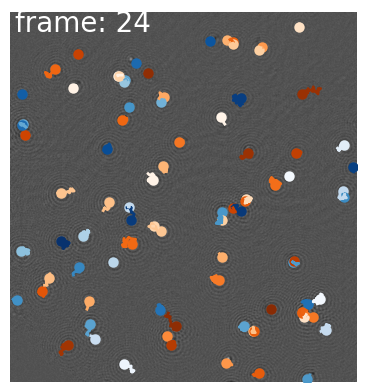

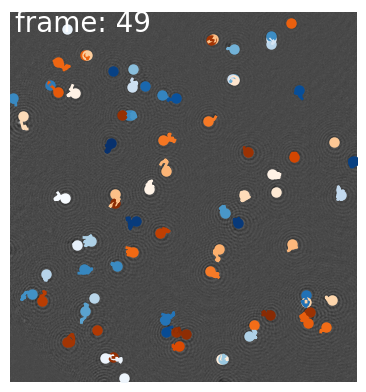

In [13]:
magik.detect(dataset_frames=(0,nr_frames))

**Extract nodes and trajectories and re-add the z-coordinate**

In [14]:

nodes = magik.nodes
traj = magik.traj

def add_z_to_nodes(nodes, predictions):
    def is_close(a, b):
        return abs(a - b) < 0.05

    new_nodes = np.hstack((nodes, np.zeros((nodes.shape[0], 1))))

    for frame_index in range(nr_frames):
        xyz_coords = predictions[frame_index]
        for xy in new_nodes:
            if int(xy[0]) == frame_index:
                for xyz in xyz_coords:
                    if is_close(xy[1]*y_size, xyz[0]) and is_close(xy[2]*x_size, xyz[1]):
                        xy[1] = xyz[0]
                        xy[2] = xyz[1]
                        xy[3] = xyz[2] 
    return new_nodes

new_nodes = add_z_to_nodes(nodes, predictions_300nm)

In [15]:
print(new_nodes)


[[  0.         740.39749146   8.31478882   2.67720532]
 [  0.         608.13816833  50.27056885   2.83979917]
 [  0.         472.60306549  56.39562988   1.01966786]
 ...
 [ 49.         459.92482758 750.17181396   3.25708342]
 [ 49.         242.82371521 790.12921143   2.59459448]
 [ 49.         245.85444641 790.37637329   2.88947916]]
